# NLP Analysis on SP500 earnings call transcripts

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.downloader.download('vader_lexicon')
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jwhiteley/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## VADER ( Valence Aware Dictionary for Sentiment Reasoning)
- VADER is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

- VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text. Resource for inspiration and definition: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [3]:
#data split from xml files

file = "../../Data/spy_2020.txt"
df = pd.read_csv(file, sep='|')
del df['order']
del df['response_type']
del df['affiliation_entity']
del df['entity']
df = df.reset_index(drop=True)
df.head()

,document,id,affiliation,name,title,type,section,text
0,2020/20200103-2337625-C.xml,0,NaN,Operator,NaN,operator,MANAGEMENT DISCUSSION SECTION,"[""Good day, and welcome to the Lamb Weston Sec..."
1,2020/20200103-2337625-C.xml,1,"Lamb Weston Holdings, Inc.",Dexter Congbalay,Vice President-Investor Relations,corprep,MANAGEMENT DISCUSSION SECTION,"[""Good morning, and thank you for joining us f..."
2,2020/20200103-2337625-C.xml,2,"Lamb Weston Holdings, Inc.",Thomas P. Werner,"President, Chief Executive Officer & Director",corprep,MANAGEMENT DISCUSSION SECTION,"[""Thank you, Dexter. Happy New Year, everyone,..."
3,2020/20200103-2337625-C.xml,3,"Lamb Weston Holdings, Inc.",Robert M. McNutt,Chief Financial Officer & Senior Vice President,corprep,MANAGEMENT DISCUSSION SECTION,"['Thanks, Tom. Good morning, everyone. As Tom ..."
4,2020/20200103-2337625-C.xml,2,"Lamb Weston Holdings, Inc.",Thomas P. Werner,"President, Chief Executive Officer & Director",corprep,MANAGEMENT DISCUSSION SECTION,"[""Thank you, Rob. Let me sum up by saying we'r..."


In [4]:
df.columns

Index(['document', 'id', 'affiliation', 'name', 'title', 'type', 'section',
       'text'],
      dtype='object')

In [20]:
# Filter out observations where Operator is speaking
df = df[df['name']!='Operator']

## Sentence level sentiment score

- Neat to see how it handles a similar sentence with a single pos/neg word swaying the sentiment

In [42]:
sentence = "This has been a really awful quarter for the firm"
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores(sentence)
print(ss)

{'neg': 0.292, 'neu': 0.708, 'pos': 0.0, 'compound': -0.5095}


In [43]:
sentence = "This has been a really fantastic quarter for the firm"
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores(sentence)
print(ss)

{'neg': 0.0, 'neu': 0.673, 'pos': 0.327, 'compound': 0.5984}


In [44]:
len(df)

36742

## Run Sentiment model using VADER lexicon

In [6]:
%%time
analyzer = SentimentIntensityAnalyzer()

i=0 #counter
compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores

while (i<len(df)):
    k = analyzer.polarity_scores(df.iloc[i]['text'])
    compval1.append(k['compound'])
    i = i+1
    
#converting sentiment values to numpy and then assign to df column
compval1 = np.array(compval1)

df['vader_score'] = compval1

CPU times: user 31.5 s, sys: 105 ms, total: 31.6 s
Wall time: 31.8 s


In [21]:
df_vader = df

Text(0.5, 1.0, 'Earnings Call Sentiment Score')

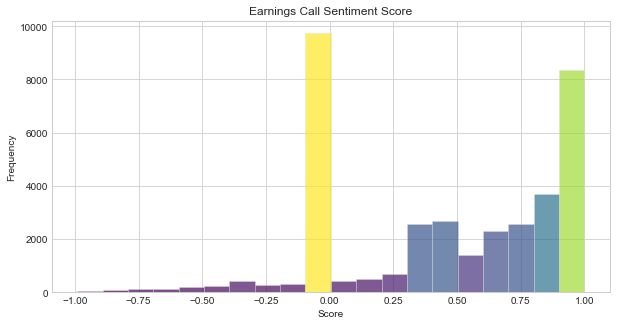

In [8]:
plt.figure(figsize=(10,5)) # Plot size
plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df_vader['vader_score'], bins=20, 
                            facecolor='#2ab0ff', 
                            edgecolor='#e0e0e0', 
                            linewidth=0.5, 
                            alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

plt.ylabel("Frequency")
plt.xlabel("Score")
plt.title("Earnings Call Sentiment Score")

## Split by Section

Let's divide up our dataframe by call section to compare sentiment across: 
- the MD&A section (scripted) 
- the Q&A section (sell-side analysts asking live questions and management's "off the cuff" response)

First, let look at the average for each group. 

We see a much higher average sentiment score in the "scripted" MD&A section. This is consistent with our understanding of prepared remarks, which often offer a rosier view of the company's performance.

In [15]:
# groupby columns section and get mean of sentiment score for each
df_vader.groupby(['section'])['vader_score'].mean()

section
MANAGEMENT DISCUSSION SECTION    0.859495
Q&A                              0.443379
Name: vader_score, dtype: float64

In [17]:
df_vader_mda = df_vader[df_vader['section'] == 'MANAGEMENT DISCUSSION SECTION']
df_vader_qa = df_vader[df_vader['section'] == 'Q&A']

Text(0.5, 1.0, 'Earnings Call Sentiment Score - MD&A Section')

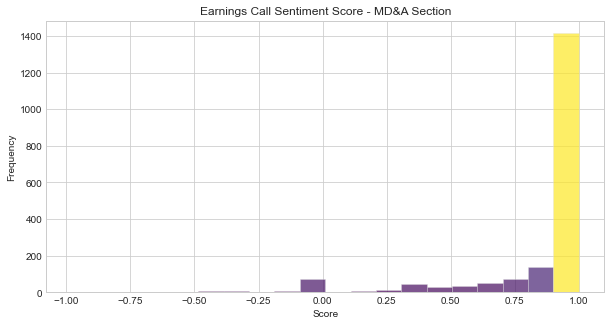

In [18]:
# Built same plot for MD&A and Q&A sections
plt.figure(figsize=(10,5)) # Plot size
plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df_vader_mda['vader_score'], bins=20, 
                            facecolor='#2ab0ff', 
                            edgecolor='#e0e0e0', 
                            linewidth=0.5, 
                            alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

plt.ylabel("Frequency")
plt.xlabel("Score")
plt.title("Earnings Call Sentiment Score - MD&A Section")



Text(0.5, 1.0, 'Earnings Call Sentiment Score - MD&A Section')

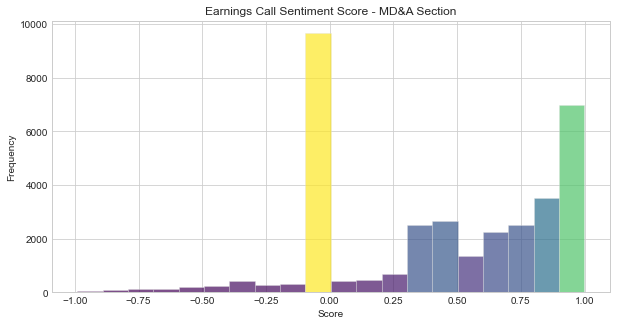

In [19]:
plt.figure(figsize=(10,5)) # Plot size
plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df_vader_qa['vader_score'], bins=20, 
                            facecolor='#2ab0ff', 
                            edgecolor='#e0e0e0', 
                            linewidth=0.5, 
                            alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

plt.ylabel("Frequency")
plt.xlabel("Score")
plt.title("Earnings Call Sentiment Score - MD&A Section")

## Takeaways:

- The distribution of earnings call sentiment in this sample skews much more positive. Again this is seen more intensely with the MD&A section split, with management reading from prepared/rosier remarks
- It is interesting that a huge bucket of observations have a sentiment score around 0, even in the non-scripted Q&A portion
- It may yield more interesting results for future sentiment analysis if one focuses on just the Q&A section, given the wider distribution of sentiment scores.